In [1]:
from pathlib import Path
import yaml
import numpy as np
from torch.utils.data import DataLoader
import wandb

from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.nn import CrossEntropyLoss
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from hydra.utils import instantiate

import os
import torch
import sys

sys.path.append("/home/erogullari/Workspace/cav-disentanglement")
from datasets import get_celeba_dataset

In [2]:
filename = Path("/home/erogullari/Workspace/cav-disentanglement/configs/dataset/celeba.yaml")
device = "cuda"

with open(filename, "r") as fp:
    config = OmegaConf.load(fp)

In [3]:
dataset = instantiate(config)
print(dataset.classes)
len(dataset)

['Non-Wearing_Necktie', 'Wearing_Necktie']


202599

In [4]:
concept_names = dataset.get_concept_names()
for i, name in enumerate(concept_names):
    print(f"Concept {i}: {name}")

Concept 0: 5_o_Clock_Shadow
Concept 1: Arched_Eyebrows
Concept 2: Attractive
Concept 3: Bags_Under_Eyes
Concept 4: Bald
Concept 5: Bangs
Concept 6: Big_Lips
Concept 7: Big_Nose
Concept 8: Black_Hair
Concept 9: Blond_Hair
Concept 10: Blurry
Concept 11: Brown_Hair
Concept 12: Bushy_Eyebrows
Concept 13: Chubby
Concept 14: Double_Chin
Concept 15: Eyeglasses
Concept 16: Goatee
Concept 17: Gray_Hair
Concept 18: Heavy_Makeup
Concept 19: High_Cheekbones
Concept 20: Male
Concept 21: Mouth_Slightly_Open
Concept 22: Mustache
Concept 23: Narrow_Eyes
Concept 24: No_Beard
Concept 25: Oval_Face
Concept 26: Pale_Skin
Concept 27: Pointy_Nose
Concept 28: Receding_Hairline
Concept 29: Rosy_Cheeks
Concept 30: Sideburns
Concept 31: Smiling
Concept 32: Straight_Hair
Concept 33: Wavy_Hair
Concept 34: Wearing_Earrings
Concept 35: Wearing_Hat
Concept 36: Wearing_Lipstick
Concept 37: Wearing_Necklace
Concept 38: Wearing_Necktie
Concept 39: Young


In [5]:
from models import get_lenet5, get_resnet18, get_simplenet, get_vgg16

in_channels = 3
input_size = config.image_size
model_name = "vgg16"
# model = get_lenet5(n_class=dataset.num_classes, in_channels=in_channels, input_size=input_size).to(device)
# model = get_simplenet(n_class=dataset.num_classes, in_channels=in_channels, input_size=input_size).to(device)
# model = get_resnet18(n_class=dataset.num_classes, pretrained=False).to(device)
model = get_vgg16(n_class=dataset.num_classes, pretrained=False).to(device)

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Sanity check
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
x, y = next(iter(loader))
print("x shape: ", x.shape)
print("y shape: ", y.shape)

y = y.long().view(-1)
y_mc = torch.nn.functional.one_hot(y, num_classes=2).float()
print("y: ", y)
print("y_mc: ", y_mc)

logits = model(x.to(device))
print("logits: ", logits)
preds = torch.argmax(logits, dim=1).cpu()
print("preds: ", preds)

x shape:  torch.Size([8, 3, 128, 128])
y shape:  torch.Size([8])
y:  tensor([0, 0, 0, 0, 0, 0, 0, 0])
y_mc:  tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
logits:  tensor([[-1.5936e-02, -6.3906e-05],
        [ 2.0939e-02, -1.5427e-02],
        [ 4.0589e-02, -9.3079e-02],
        [ 2.4525e-02, -3.0084e-02],
        [ 2.2692e-02, -5.4382e-03],
        [ 3.0813e-02, -3.4537e-02],
        [ 8.4092e-03, -5.6958e-02],
        [ 5.0122e-02, -5.3283e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds:  tensor([1, 0, 0, 0, 0, 0, 0, 0])


In [7]:
from torchmetrics import Precision, Recall, F1Score, Accuracy
from torch.nn.functional import one_hot

class Classifier(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate=1e-3):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.loss = CrossEntropyLoss()
        
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = Precision(task="multiclass", num_classes=num_classes, average="macro")
        self.recall = Recall(task="multiclass", num_classes=num_classes, average="macro")
        self.f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro")
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.long().view(-1)
        y_mc = one_hot(y, num_classes=2).float()
        logits = self(x)
        loss = self.loss(logits, y_mc)
        preds = torch.argmax(logits, dim=1)
        self.log("train_loss", loss)
        self.log("train_precision", self.precision(preds, y))
        self.log("train_recall", self.recall(preds, y))
        self.log("train_f1", self.f1(preds, y))
        self.log("train_accuracy", self.accuracy(preds, y))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.long().view(-1)
        y_mc = one_hot(y, num_classes=2).float()
        logits = self(x)
        loss = self.loss(logits, y_mc)
        preds = torch.argmax(logits, dim=1)
        
        self.log("val_loss", loss)
        self.log("val_precision", self.precision(preds, y))
        self.log("val_recall", self.recall(preds, y))
        self.log("val_f1", self.f1(preds, y))
        self.log("val_accuracy", self.accuracy(preds, y))
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": scheduler,
            #     "interval": "epoch",  # or "step"
            #     "frequency": 1,
            # },
        }


## Training

In [8]:
wandb_api_key = "fd23a775c05c87e463c7f435486e662d28cac69d"
wandb_project_name = "elements-training-1"

os.environ["WANDB_API_KEY"] = wandb_api_key
wandb_logger = WandbLogger(
    project=wandb_project_name,
    # api_key=wandb_api_key,
    name=f"{model_name}-necktie-bce"
)

In [9]:
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="/media/erogullari/checkpoints/cache/",
    filename=f"{model_name}" + "-necktie-bce-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=3,
    verbose=True
)

lightning_model = Classifier(model, dataset.num_classes)
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Train size: 162079, Val size: 40520


In [11]:
trainer.fit(lightning_model, train_loader, val_loader)

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#t

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /media/erogullari/checkpoints/cache exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | VGG                 | 134 M  | train
1 | loss      | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
5 | f1        | MulticlassF1Score   | 0      | train
----------------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)
48        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 20260/20260 [20:16<00:00, 16.66it/s, v_num=bh14]

Epoch 0, global step 20260: 'val_loss' reached 0.15311 (best 0.15311), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=00-val_loss=0.15.ckpt' as top 3


Epoch 1: 100%|██████████| 20260/20260 [20:13<00:00, 16.69it/s, v_num=bh14]

Epoch 1, global step 40520: 'val_loss' reached 0.11580 (best 0.11580), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=01-val_loss=0.12.ckpt' as top 3


Epoch 2: 100%|██████████| 20260/20260 [20:14<00:00, 16.69it/s, v_num=bh14]

Epoch 2, global step 60780: 'val_loss' reached 0.10556 (best 0.10556), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=02-val_loss=0.11.ckpt' as top 3


Epoch 3: 100%|██████████| 20260/20260 [20:19<00:00, 16.61it/s, v_num=bh14]

Epoch 3, global step 81040: 'val_loss' reached 0.10802 (best 0.10556), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=03-val_loss=0.11.ckpt' as top 3


Epoch 4: 100%|██████████| 20260/20260 [20:15<00:00, 16.67it/s, v_num=bh14]

Epoch 4, global step 101300: 'val_loss' reached 0.09885 (best 0.09885), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=04-val_loss=0.10.ckpt' as top 3


Epoch 5: 100%|██████████| 20260/20260 [20:16<00:00, 16.65it/s, v_num=bh14]

Epoch 5, global step 121560: 'val_loss' reached 0.09403 (best 0.09403), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=05-val_loss=0.09.ckpt' as top 3


Epoch 6: 100%|██████████| 20260/20260 [20:13<00:00, 16.70it/s, v_num=bh14]

Epoch 6, global step 141820: 'val_loss' reached 0.09145 (best 0.09145), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=06-val_loss=0.09.ckpt' as top 3


Epoch 7: 100%|██████████| 20260/20260 [20:22<00:00, 16.57it/s, v_num=bh14]

Epoch 7, global step 162080: 'val_loss' was not in top 3


Epoch 8: 100%|██████████| 20260/20260 [20:18<00:00, 16.63it/s, v_num=bh14]

Epoch 8, global step 182340: 'val_loss' reached 0.09012 (best 0.09012), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=08-val_loss=0.09.ckpt' as top 3


Epoch 9: 100%|██████████| 20260/20260 [20:12<00:00, 16.71it/s, v_num=bh14]

Epoch 9, global step 202600: 'val_loss' reached 0.08778 (best 0.08778), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=09-val_loss=0.09.ckpt' as top 3


Epoch 10: 100%|██████████| 20260/20260 [20:11<00:00, 16.72it/s, v_num=bh14]

Epoch 10, global step 222860: 'val_loss' was not in top 3


Epoch 11: 100%|██████████| 20260/20260 [20:17<00:00, 16.64it/s, v_num=bh14]

Epoch 11, global step 243120: 'val_loss' reached 0.08871 (best 0.08778), saving model to '/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=11-val_loss=0.09.ckpt' as top 3


Epoch 12: 100%|██████████| 20260/20260 [20:13<00:00, 16.70it/s, v_num=bh14]

Epoch 12, global step 263380: 'val_loss' was not in top 3


Epoch 13: 100%|██████████| 20260/20260 [20:17<00:00, 16.64it/s, v_num=bh14]

Epoch 13, global step 283640: 'val_loss' was not in top 3


Epoch 14: 100%|██████████| 20260/20260 [20:12<00:00, 16.71it/s, v_num=bh14]

Epoch 14, global step 303900: 'val_loss' was not in top 3


Epoch 15: 100%|██████████| 20260/20260 [20:13<00:00, 16.69it/s, v_num=bh14]

Epoch 15, global step 324160: 'val_loss' was not in top 3


Epoch 16: 100%|██████████| 20260/20260 [20:11<00:00, 16.72it/s, v_num=bh14]

Epoch 16, global step 344420: 'val_loss' was not in top 3


Epoch 17: 100%|██████████| 20260/20260 [20:13<00:00, 16.69it/s, v_num=bh14]

Epoch 17, global step 364680: 'val_loss' was not in top 3


Epoch 18: 100%|██████████| 20260/20260 [20:15<00:00, 16.67it/s, v_num=bh14]

Epoch 18, global step 384940: 'val_loss' was not in top 3


Epoch 19: 100%|██████████| 20260/20260 [20:14<00:00, 16.68it/s, v_num=bh14]

Epoch 19, global step 405200: 'val_loss' was not in top 3
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20260/20260 [20:14<00:00, 16.68it/s, v_num=bh14]


In [28]:
# Get predictions on validation set
lightning_model.eval().to(device)
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = lightning_model(x)
        preds = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [29]:
accuracy = ((all_preds > .5) * 1 == all_labels).mean()  # type: ignore
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9895


In [30]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix

num_classes = all_preds.shape[1]

# per-class ROC + precision/recall at 0.5
fpr = {}
tpr = {}
roc_auc = {}
precision_per = {}
recall_per = {}
support_per = {}

for i in range(num_classes):
    y_true = all_labels[:, i].astype(int)
    y_score = all_preds[:, i]
    y_pred = (y_score > 0.5).astype(int)

    # precision / recall at threshold 0.5 (sklearn)
    precision_per[i] = precision_score(y_true, y_pred, zero_division=0)
    recall_per[i] = recall_score(y_true, y_pred, zero_division=0)

    # support and confusion for diagnostics
    support_per[i] = int(y_true.sum())
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    print(f"cls {i}: support={support_per[i]}  TP={tp}  FP={fp}  FN={fn}  TN={tn}  precision={precision_per[i]:.3f}  recall={recall_per[i]:.3f}")

# macro averages (use sklearn to match torchmetrics)
precision_macro = precision_score(all_labels.astype(int), (all_preds > 0.5).astype(int), average="macro", zero_division=0)
recall_macro = recall_score(all_labels.astype(int), (all_preds > 0.5).astype(int), average="macro", zero_division=0)


print("\nSummary:")
print(f"Macro Precision@0.5: {precision_macro:.3f}")
print(f"Macro Recall@0.5:    {recall_macro:.3f}")

cls 0: support=19  TP=15  FP=0  FN=4  TN=1981  precision=1.000  recall=0.789
cls 1: support=21  TP=12  FP=0  FN=9  TN=1979  precision=1.000  recall=0.571
cls 2: support=19  TP=15  FP=0  FN=4  TN=1981  precision=1.000  recall=0.789
cls 3: support=169  TP=144  FP=11  FN=25  TN=1820  precision=0.929  recall=0.852
cls 4: support=19  TP=16  FP=3  FN=3  TN=1978  precision=0.842  recall=0.842
cls 5: support=17  TP=14  FP=6  FN=3  TN=1977  precision=0.700  recall=0.824
cls 6: support=18  TP=17  FP=2  FN=1  TN=1980  precision=0.895  recall=0.944
cls 7: support=192  TP=189  FP=5  FN=3  TN=1803  precision=0.974  recall=0.984
cls 8: support=18  TP=18  FP=5  FN=0  TN=1977  precision=0.783  recall=1.000
cls 9: support=23  TP=22  FP=2  FN=1  TN=1975  precision=0.917  recall=0.957
cls 10: support=16  TP=13  FP=1  FN=3  TN=1983  precision=0.929  recall=0.812
cls 11: support=183  TP=179  FP=2  FN=4  TN=1815  precision=0.989  recall=0.978
cls 12: support=13  TP=7  FP=7  FN=6  TN=1980  precision=0.500  re

cls 103: support=23  TP=6  FP=2  FN=17  TN=1975  precision=0.750  recall=0.261
cls 104: support=225  TP=158  FP=36  FN=67  TN=1739  precision=0.814  recall=0.702
cls 105: support=128  TP=127  FP=0  FN=1  TN=1872  precision=1.000  recall=0.992
cls 106: support=139  TP=133  FP=0  FN=6  TN=1861  precision=1.000  recall=0.957
cls 107: support=126  TP=120  FP=0  FN=6  TN=1874  precision=1.000  recall=0.952
cls 108: support=17  TP=17  FP=5  FN=0  TN=1978  precision=0.773  recall=1.000
cls 109: support=20  TP=12  FP=1  FN=8  TN=1979  precision=0.923  recall=0.600
cls 110: support=31  TP=22  FP=3  FN=9  TN=1966  precision=0.880  recall=0.710
cls 111: support=229  TP=203  FP=16  FN=26  TN=1755  precision=0.927  recall=0.886
cls 112: support=26  TP=23  FP=5  FN=3  TN=1969  precision=0.821  recall=0.885
cls 113: support=18  TP=15  FP=3  FN=3  TN=1979  precision=0.833  recall=0.833
cls 114: support=30  TP=27  FP=1  FN=3  TN=1969  precision=0.964  recall=0.900
cls 115: support=215  TP=211  FP=15  F

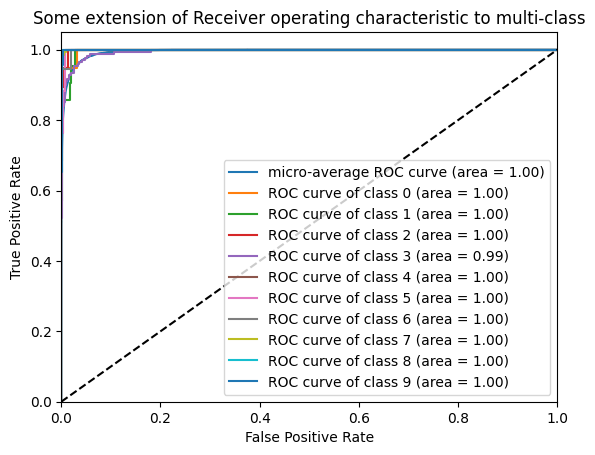

In [31]:
num_classes_roc = 10

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes_roc):

    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(num_classes_roc):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ckpt_path = "/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/vgg16-bce-val_loss=0.04.ckpt"
# backbone = get_simplenet(n_class=153, in_channels=3, input_size=224, pretrained=False)
backbone = get_vgg16(n_class=dataset.num_classes, pretrained=False).to(device)
classifier = Classifier.load_from_checkpoint(ckpt_path, model=backbone, num_classes=dataset.num_classes)
classifier.eval().cpu()
save_path = f"/media/erogullari/checkpoints/checkpoint_{model_name}_elements.pth"
torch.save(classifier.model.state_dict(), save_path)
print(f"File saved to {save_path}")
list(backbone.named_modules())

File saved to /media/erogullari/checkpoints/checkpoint_vgg16_elements.pth


[('',
  VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPool2d(ke

In [19]:
# Get predictions on validation set
classifier.eval().to(device)
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = classifier(x)
        preds = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [20]:
accuracy = ((all_preds > .5) * 1 == all_labels).mean()  # type: ignore
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9740


In [21]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix

num_classes = all_preds.shape[1]

# per-class ROC + precision/recall at 0.5
fpr = {}
tpr = {}
roc_auc = {}
precision_per = {}
recall_per = {}
support_per = {}

for i in range(num_classes):
    y_true = all_labels[:, i].astype(int)
    y_score = all_preds[:, i]
    y_pred = (y_score > 0.5).astype(int)

    # precision / recall at threshold 0.5 (sklearn)
    precision_per[i] = precision_score(y_true, y_pred, zero_division=0)
    recall_per[i] = recall_score(y_true, y_pred, zero_division=0)

    # support and confusion for diagnostics
    support_per[i] = int(y_true.sum())
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    print(f"cls {i}: support={support_per[i]}  TP={tp}  FP={fp}  FN={fn}  TN={tn}  precision={precision_per[i]:.3f}  recall={recall_per[i]:.3f}")

# macro averages (use sklearn to match torchmetrics)
precision_macro = precision_score(all_labels.astype(int), (all_preds > 0.5).astype(int), average="macro", zero_division=0)
recall_macro = recall_score(all_labels.astype(int), (all_preds > 0.5).astype(int), average="macro", zero_division=0)


print("\nSummary:")
print(f"Macro Precision@0.5: {precision_macro:.3f}")
print(f"Macro Recall@0.5:    {recall_macro:.3f}")

cls 0: support=16  TP=4  FP=1  FN=12  TN=1983  precision=0.800  recall=0.250
cls 1: support=22  TP=11  FP=11  FN=11  TN=1967  precision=0.500  recall=0.500
cls 2: support=14  TP=2  FP=2  FN=12  TN=1984  precision=0.500  recall=0.143
cls 3: support=157  TP=31  FP=24  FN=126  TN=1819  precision=0.564  recall=0.197
cls 4: support=13  TP=5  FP=6  FN=8  TN=1981  precision=0.455  recall=0.385
cls 5: support=21  TP=2  FP=5  FN=19  TN=1974  precision=0.286  recall=0.095
cls 6: support=17  TP=4  FP=8  FN=13  TN=1975  precision=0.333  recall=0.235
cls 7: support=180  TP=50  FP=65  FN=130  TN=1755  precision=0.435  recall=0.278
cls 8: support=17  TP=8  FP=2  FN=9  TN=1981  precision=0.800  recall=0.471
cls 9: support=20  TP=15  FP=0  FN=5  TN=1980  precision=1.000  recall=0.750
cls 10: support=15  TP=8  FP=0  FN=7  TN=1985  precision=1.000  recall=0.533
cls 11: support=190  TP=111  FP=1  FN=79  TN=1809  precision=0.991  recall=0.584
cls 12: support=15  TP=5  FP=1  FN=10  TN=1984  precision=0.833 

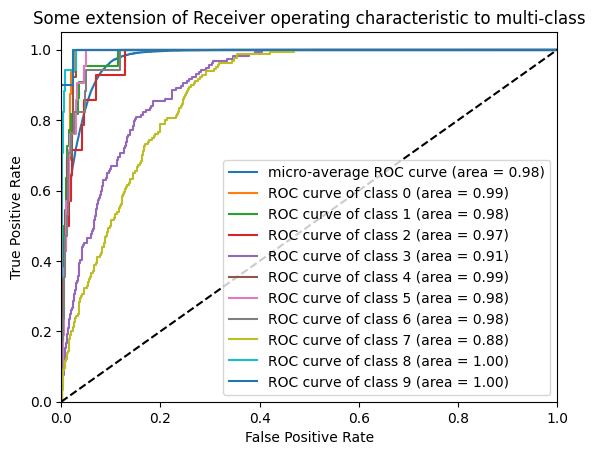

In [22]:
num_classes_roc = 10

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes_roc):

    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(num_classes_roc):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Activation Steering Evaluation

In [8]:
gender_classifier_path = Path("/media/erogullari/checkpoints/cache/vgg16-gender-bce-epoch=08-val_loss=0.06.ckpt")   # acc 0.98
necktie_classifier_path = Path("/media/erogullari/checkpoints/cache/vgg16-necktie-bce-epoch=11-val_loss=0.09.ckpt") # acc 0.97
decodings_dir = Path("/home/erogullari/Workspace/cav-disentanglement/results/activation_steering/celeba/decodings")

Using device: cuda


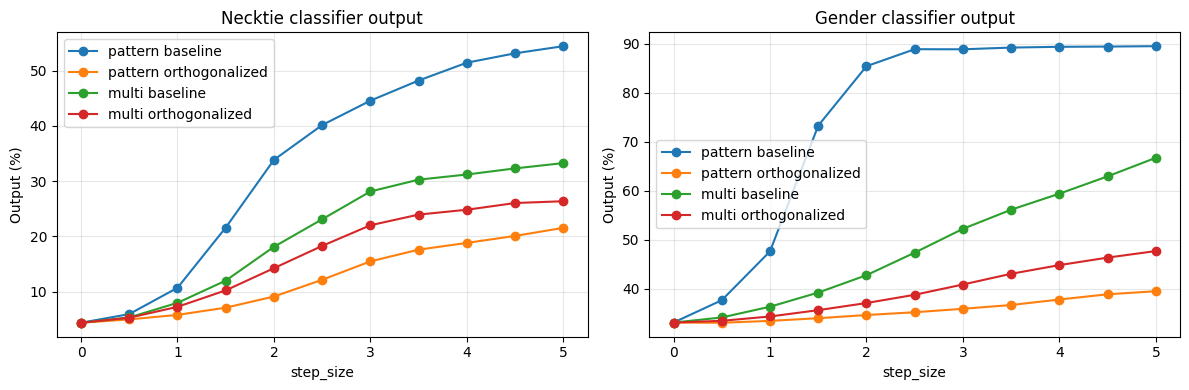

In [16]:
# --- Activation Steering Evaluation ---
from torchvision.io import read_image
from torchvision import transforms as T


def _format_float(value: float) -> str:
    if float(value).is_integer():
        return str(int(value))
    text = f"{value}"
    if "e" in text or "E" in text:
        return f"{value:.4g}"
    return text.rstrip("0").rstrip(".") if "." in text else text


def _find_step_index(step_sizes, target=0.0, tol=1e-6):
    for i, s in enumerate(step_sizes):
        if abs(float(s) - float(target)) <= tol:
            return i
    raise ValueError(f"step_size {target} not found in {step_sizes}")


def _alpha_dir(root: Path, cav_type: str, alpha: float) -> Path:
    return root / cav_type / f"alpha{_format_float(alpha)}"


def _list_step_sizes(alpha_dir: Path):
    img_dirs = sorted([p for p in alpha_dir.glob("img*") if p.is_dir()],
                      key=lambda p: int(p.name.replace("img", "")))
    if not img_dirs:
        raise FileNotFoundError(f"No img* directories found in {alpha_dir}")
    sample_dir = img_dirs[0]
    step_sizes = []
    for f in sample_dir.glob("step_size*.png"):
        suffix = f.stem.replace("step_size", "")
        try:
            step_sizes.append(float(suffix))
        except ValueError:
            continue
    return sorted(step_sizes)


def _collect_paths(alpha_dir: Path, step_size: float):
    step_suffix = _format_float(step_size)
    img_dirs = sorted([p for p in alpha_dir.glob("img*") if p.is_dir()],
                      key=lambda p: int(p.name.replace("img", "")))
    paths = []
    for d in img_dirs:
        p = d / f"step_size{step_suffix}.png"
        if p.exists():
            paths.append(p)
    return paths


def _load_classifier(ckpt_path: Path, num_classes: int, device: str):
    backbone = get_vgg16(n_class=num_classes, pretrained=False).to(device)
    clf = Classifier.load_from_checkpoint(str(ckpt_path), model=backbone, num_classes=num_classes)
    clf = clf.to(device)
    clf.eval()
    return clf


def _predict_means(gender_model, necktie_model, paths, transform, device, batch_size=8):
    if not paths:
        raise ValueError("No image paths provided for prediction.")
    gender_vals = []
    necktie_vals = []

    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        imgs = []
        for p in batch_paths:
            img = read_image(str(p))
            if img.shape[0] > 3:
                img = img[:3]
            imgs.append(transform(img))
        batch = torch.stack(imgs).to(device)

        with torch.no_grad():
            gender_probs = torch.sigmoid(gender_model(batch))[:, 1].detach().cpu()
            necktie_probs = torch.sigmoid(necktie_model(batch))[:, 1].detach().cpu()

        gender_vals.append(gender_probs)
        necktie_vals.append(necktie_probs)

    gender_mean = torch.cat(gender_vals).mean().item() * 100.0
    necktie_mean = torch.cat(necktie_vals).mean().item() * 100.0
    return gender_mean, necktie_mean


def _evaluate_alpha(decodings_root: Path, cav_type: str, alpha: float, gender_model, necktie_model,
                    transform, device, batch_size=8, expected_samples=20):
    alpha_dir = _alpha_dir(decodings_root, cav_type, alpha)
    if not alpha_dir.exists():
        raise FileNotFoundError(f"Alpha dir not found: {alpha_dir}")

    step_sizes = _list_step_sizes(alpha_dir)
    gender_means = []
    necktie_means = []

    for step in step_sizes:
        paths = _collect_paths(alpha_dir, step)
        if expected_samples is not None and len(paths) != expected_samples:
            print(f"Warning: {alpha_dir} step_size{_format_float(step)} has {len(paths)} images")
        gender_mean, necktie_mean = _predict_means(
            gender_model=gender_model,
            necktie_model=necktie_model,
            paths=paths,
            transform=transform,
            device=device,
            batch_size=batch_size,
        )
        gender_means.append(gender_mean)
        necktie_means.append(necktie_mean)

    return {
        "step_sizes": step_sizes,
        "gender": gender_means,
        "necktie": necktie_means,
    }


def run_activation_steering_eval(alpha: float, delta: bool = False, batch_size: int = 8, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    gender_model = _load_classifier(gender_classifier_path, num_classes=2, device=device)
    necktie_model = _load_classifier(necktie_classifier_path, num_classes=2, device=device)

    image_transform = T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Resize((input_size, input_size)),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    line_specs = [
        ("pattern baseline", "pattern_cav", 0.0),
        ("pattern orthogonalized", "pattern_cav", alpha),
        ("multi baseline", "multi_cav", 0.0),
        ("multi orthogonalized", "multi_cav", alpha),
    ]

    results = []
    for label, cav_type, alpha_value in line_specs:
        res = _evaluate_alpha(
            decodings_root=decodings_dir,
            cav_type=cav_type,
            alpha=alpha_value,
            gender_model=gender_model,
            necktie_model=necktie_model,
            transform=image_transform,
            device=device,
            batch_size=batch_size,
        )
        results.append((label, res))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].set_title("Necktie classifier output")
    axes[1].set_title("Gender classifier output")

    for label, res in results:
        step_sizes = res["step_sizes"]
        necktie_vals = np.array(res["necktie"], dtype=float)
        gender_vals = np.array(res["gender"], dtype=float)

        if delta:
            idx0 = _find_step_index(step_sizes, target=0.0)
            necktie_vals = necktie_vals - necktie_vals[idx0]
            gender_vals = gender_vals - gender_vals[idx0]

        axes[0].plot(step_sizes, necktie_vals, marker="o", label=label)
        axes[1].plot(step_sizes, gender_vals, marker="o", label=label)

    ylabel = "Δ output (%)" if delta else "Output (%)"
    axes[0].set_xlabel("step_size")
    axes[1].set_xlabel("step_size")
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel(ylabel)

    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    save_path = f"/home/erogullari/Workspace/cav-disentanglement/media/activation_steering/gender_necktie_classifier_results{'_delta' if delta else ''}.pdf"
    plt.savefig(save_path, dpi=300, format="pdf")
    return results


# --- Run ---
_ = run_activation_steering_eval(alpha=1.0, delta=False)

Using device: cuda


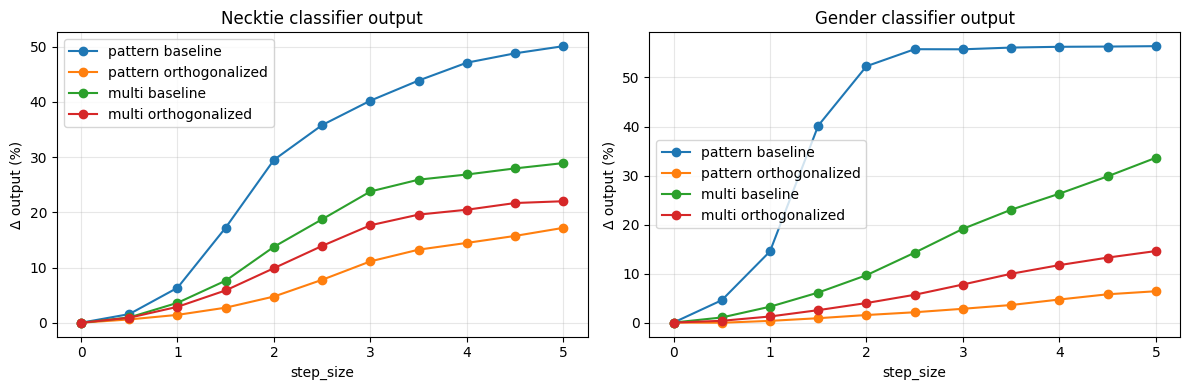

In [17]:
_ = run_activation_steering_eval(alpha=1.0, delta=True)